## Dataset Audit

### CODE

In [12]:
%reload_ext autoreload
%autoreload 2

In [13]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

from IPython.display import display
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.dpi": 120})

In [14]:
@dataclass
class AuditConfig:
    dataset_root: Path
    speech_top_db: float = 30.0
    target_sr_for_speech_ratio: int | None = 16000
    reports_dir: Path | None = None
    save_tables: bool = True
    save_figures: bool = False
    save_text_report: bool = True
    figure_dpi: int = 120
    text_report_name: str | None = None
    max_error_examples: int = 5


@dataclass
class AudioRecord:
    class_label: str
    rel_path: str
    file_path: str
    duration_sec: float
    samplerate: int
    speech_ratio: float
    filesize_mb: float
    rms_db: float
    zero_cross_rate: float


def _discover_class_roots(dataset_root: Path) -> List[Path]:
    if not dataset_root.exists():
        raise FileNotFoundError(f"Dataset root {dataset_root} does not exist")
    class_dirs = [p for p in sorted(dataset_root.iterdir()) if p.is_dir()]
    if not class_dirs:
        raise RuntimeError(f"No class directories found under {dataset_root}")
    return class_dirs


def _iter_mp3_files(class_dir: Path) -> Iterable[Path]:
    yield from class_dir.rglob("*.mp3")


def _compute_speech_ratio(signal: np.ndarray, sr: int, top_db: float) -> float:
    if len(signal) == 0:
        return np.nan
    non_silent = librosa.effects.split(signal, top_db=top_db)
    if len(non_silent) == 0:
        return 0.0
    voiced = sum((end - start) for start, end in non_silent)
    total = len(signal)
    return float(voiced / total)


def _zero_crossings(signal: np.ndarray) -> float:
    if len(signal) == 0:
        return np.nan
    zero_crossings = np.nonzero(np.diff(np.signbit(signal)))[0]
    return float(len(zero_crossings) / len(signal))


def analyze_audio_file(
    class_label: str,
    file_path: Path,
    config: AuditConfig,
) -> AudioRecord:
    signal, sr = librosa.load(
        str(file_path),
        sr=config.target_sr_for_speech_ratio,
        mono=True,
    )
    duration_sec = float(len(signal) / sr) if len(signal) else 0.0
    speech_ratio = _compute_speech_ratio(signal, sr, config.speech_top_db)
    rms = float(np.sqrt(np.mean(signal ** 2))) if len(signal) else 0.0
    rms_db = 20 * np.log10(rms + 1e-12)
    zcr = _zero_crossings(signal)

    dataset_root = config.dataset_root
    rel_path = str(file_path.relative_to(dataset_root))
    filesize_mb = file_path.stat().st_size / (1024 ** 2)

    return AudioRecord(
        class_label=class_label,
        rel_path=rel_path,
        file_path=str(file_path),
        duration_sec=duration_sec,
        samplerate=sr,
        speech_ratio=speech_ratio,
        filesize_mb=float(filesize_mb),
        rms_db=float(rms_db),
        zero_cross_rate=float(zcr),
    )


def gather_dataset_overview(config: AuditConfig) -> Tuple[pd.DataFrame, List[Tuple[Path, str]]]:
    dataset_root = config.dataset_root
    class_dirs = _discover_class_roots(dataset_root)
    records: List[AudioRecord] = []
    errors: List[Tuple[Path, str]] = []

    for class_dir in class_dirs:
        class_label = class_dir.name
        mp3_files = list(_iter_mp3_files(class_dir))
        if not mp3_files:
            errors.append((class_dir, "No mp3 files found"))
            continue
        for audio_path in tqdm(mp3_files, desc=f"Processing {class_label}"):
            try:
                record = analyze_audio_file(
                    class_label,
                    audio_path,
                    config,
                )
                records.append(record)
            except Exception as exc:
                errors.append((audio_path, str(exc)))
    df = pd.DataFrame([r.__dict__ for r in records])
    return df, errors

In [15]:
def _safe_mode(series: pd.Series) -> float:
    modes = series.mode(dropna=True)
    return float(modes.iloc[0]) if not modes.empty else np.nan


def build_class_summary(analysis_df: pd.DataFrame) -> pd.DataFrame:
    if analysis_df.empty:
        columns = [
            "file_count",
            "total_duration_sec",
            "avg_duration_sec",
            "std_duration_sec",
            "median_duration_sec",
            "avg_speech_ratio",
            "std_speech_ratio",
            "avg_rms_db",
            "avg_zero_cross_rate",
            "samplerate_mode",
            "samplerate_variety",
            "total_filesize_mb",
            "total_duration_hours",
        ]
        return pd.DataFrame(columns=columns)

    class_summary = (
        analysis_df.groupby("class_label", observed=True)
        .agg(
            file_count=("file_path", "count"),
            total_duration_sec=("duration_sec", "sum"),
            avg_duration_sec=("duration_sec", "mean"),
            std_duration_sec=("duration_sec", "std"),
            median_duration_sec=("duration_sec", "median"),
            avg_speech_ratio=("speech_ratio", "mean"),
            std_speech_ratio=("speech_ratio", "std"),
            avg_rms_db=("rms_db", "mean"),
            avg_zero_cross_rate=("zero_cross_rate", "mean"),
            samplerate_mode=("samplerate", _safe_mode),
            samplerate_variety=("samplerate", "nunique"),
            total_filesize_mb=("filesize_mb", "sum"),
        )
        .sort_values("file_count", ascending=False)
    )
    class_summary["total_duration_hours"] = class_summary["total_duration_sec"] / 3600
    return class_summary


def format_class_summary(class_summary: pd.DataFrame) -> pd.DataFrame:
    if class_summary.empty:
        return class_summary

    formatted = class_summary.copy()

    def _fmt(value: float, fmt: str) -> str:
        return fmt.format(value) if pd.notna(value) else "—"

    formatted["avg_duration_sec"] = formatted["avg_duration_sec"].apply(lambda x: _fmt(x, "{:.1f}s"))
    formatted["std_duration_sec"] = formatted["std_duration_sec"].apply(lambda x: _fmt(x, "{:.1f}s"))
    formatted["median_duration_sec"] = formatted["median_duration_sec"].apply(lambda x: _fmt(x, "{:.1f}s"))
    formatted["avg_speech_ratio"] = formatted["avg_speech_ratio"].apply(lambda x: _fmt(x * 100, "{:.1f}%") if pd.notna(x) else "—")
    formatted["std_speech_ratio"] = formatted["std_speech_ratio"].apply(lambda x: _fmt(x * 100, "{:.1f}%") if pd.notna(x) else "—")
    formatted["total_duration_hours"] = formatted["total_duration_hours"].apply(lambda x: _fmt(x, "{:.2f}h"))
    formatted["avg_rms_db"] = formatted["avg_rms_db"].apply(lambda x: _fmt(x, "{:.1f} dB"))
    formatted["avg_zero_cross_rate"] = formatted["avg_zero_cross_rate"].apply(lambda x: _fmt(x * 100, "{:.2f}%") if pd.notna(x) else "—")
    formatted["total_filesize_mb"] = formatted["total_filesize_mb"].apply(lambda x: _fmt(x, "{:.1f} MB"))
    return formatted


def build_text_overview(
    analysis_df: pd.DataFrame,
    class_summary: pd.DataFrame,
    errors: List[Tuple[Path, str]],
    config: AuditConfig,
) -> str:
    lines: List[str] = []
    clip_count = len(analysis_df)
    class_count = analysis_df["class_label"].nunique() if not analysis_df.empty else 0
    lines.append(f"Loaded {clip_count} audio clips from {class_count} classes")

    if clip_count:
        overall_duration_hours = analysis_df["duration_sec"].sum() / 3600
        overall_filesize_gb = analysis_df["filesize_mb"].sum() / 1024
        lines.append(f"Total audio duration: {overall_duration_hours:.2f} hours")
        lines.append(f"Total file size: {overall_filesize_gb:.2f} GB")

        samplerate_counts = analysis_df["samplerate"].value_counts().sort_index()
        if not samplerate_counts.empty:
            lines.append("Sample rate distribution (Hz):")
            lines.append(samplerate_counts.to_string())
        else:
            lines.append("Sample rate distribution (Hz): no data")

        if not class_summary.empty:
            speech_stats = class_summary[["avg_speech_ratio", "std_speech_ratio"]].copy()
            speech_stats = speech_stats.mul(100).round(2)
            speech_stats.columns = ["mean_%", "std_%"]
            lines.append("")
            lines.append("Speech ratio (mean ± std) by class (%):")
            lines.append(speech_stats.to_string())

    if errors:
        lines.append("")
        lines.append(f"Encountered {len(errors)} issues during processing")
        for path, message in errors[: config.max_error_examples]:
            lines.append(f" - {path}: {message}")
        remaining = len(errors) - config.max_error_examples
        if remaining > 0:
            lines.append(f"   ...and {remaining} more")

    return "\n".join(lines)


def create_overview_figures(
    analysis_df: pd.DataFrame,
    class_summary: pd.DataFrame,
) -> List[plt.Figure]:
    if analysis_df.empty or class_summary.empty:
        return []

    figures: List[plt.Figure] = []

    fig1, axes = plt.subplots(2, 2, figsize=(12, 10))
    class_summary["file_count"].plot.bar(ax=axes[0, 0], color="#2a9d8f")
    axes[0, 0].set_title("Clip Count by Class")
    axes[0, 0].set_xlabel("Class")
    axes[0, 0].set_ylabel("Clips")
    axes[0, 0].tick_params(axis="x", rotation=45)

    duration_values = class_summary["total_duration_sec"].values
    if duration_values.sum() > 0:
        axes[0, 1].pie(
            duration_values,
            labels=class_summary.index,
            autopct="%1.1f%%",
            startangle=140,
            colors=sns.color_palette("pastel"),
        )
        axes[0, 1].set_title("Duration Share by Class")
    else:
        axes[0, 1].axis("off")
        axes[0, 1].text(0.5, 0.5, "No duration data", ha="center", va="center")

    sns.histplot(
        analysis_df,
        x="duration_sec",
        hue="class_label",
        bins=30,
        multiple="stack",
        ax=axes[1, 0],
    )
    axes[1, 0].set_title("Clip Duration Distribution")
    axes[1, 0].set_xlabel("Duration (seconds)")
    axes[1, 0].set_ylabel("Count")

    sns.boxplot(
        data=analysis_df,
        x="class_label",
        y="speech_ratio",
        ax=axes[1, 1],
    )
    axes[1, 1].set_title("Speech Coverage by Class")
    axes[1, 1].set_xlabel("Class")
    axes[1, 1].set_ylabel("Speech Ratio")
    axes[1, 1].tick_params(axis="x", rotation=45)

    fig1.tight_layout()
    figures.append(fig1)

    fig2, ax_rms = plt.subplots(figsize=(8, 5))
    sns.violinplot(
        data=analysis_df,
        x="class_label",
        y="rms_db",
        inner="quartile",
        ax=ax_rms,
    )
    ax_rms.set_title("RMS Energy Distribution (dB)")
    ax_rms.set_xlabel("Class")
    ax_rms.set_ylabel("RMS (dB)")
    ax_rms.tick_params(axis="x", rotation=45)

    fig2.tight_layout()
    figures.append(fig2)

    return figures


def export_reports(
    analysis_df: pd.DataFrame,
    class_summary: pd.DataFrame,
    figures: List[plt.Figure],
    text_overview: str,
    config: AuditConfig,
) -> Dict[str, Path | List[Path]]:
    exports: Dict[str, Path | List[Path]] = {}
    if not (config.save_tables or config.save_figures or config.save_text_report):
        return exports

    reports_dir = config.reports_dir or (Path.cwd() / "reports")
    reports_dir.mkdir(parents=True, exist_ok=True)
    dataset_name = config.dataset_root.name

    if config.save_tables and not analysis_df.empty:
        detail_csv = reports_dir / f"{dataset_name}_clip_inventory.csv"
        summary_csv = reports_dir / f"{dataset_name}_class_summary.csv"
        analysis_df.to_csv(detail_csv, index=False)
        class_summary.reset_index().to_csv(summary_csv, index=False)
        exports["detail_csv"] = detail_csv
        exports["summary_csv"] = summary_csv

    if config.save_figures and figures:
        figure_paths: List[Path] = []
        for idx, fig in enumerate(figures, start=1):
            fig_path = reports_dir / f"{dataset_name}_figure_{idx}.png"
            fig.savefig(fig_path, dpi=config.figure_dpi, bbox_inches="tight")
            figure_paths.append(fig_path)
        exports["figure_paths"] = figure_paths

    if config.save_text_report:
        text_name = config.text_report_name or f"{dataset_name}_summary.txt"
        text_path = reports_dir / text_name
        text_path.write_text(text_overview + "\n", encoding="utf-8")
        exports["text_report"] = text_path

    return exports


def run_dataset_audit(config: AuditConfig) -> Dict[str, object]:
    analysis_df, errors = gather_dataset_overview(config)
    class_summary = build_class_summary(analysis_df)
    formatted_summary = format_class_summary(class_summary)

    if not formatted_summary.empty:
        display(formatted_summary)
    else:
        print("No audio samples processed. Check dataset path or file extensions.")

    text_overview = build_text_overview(analysis_df, class_summary, errors, config)
    print(text_overview)

    figures = create_overview_figures(analysis_df, class_summary)
    for fig in figures:
        display(fig)
        plt.close(fig)

    exports = export_reports(analysis_df, class_summary, figures, text_overview, config)
    if exports:
        print("\nSaved artifacts:")
        for label, path_info in exports.items():
            if isinstance(path_info, list):
                for item in path_info:
                    print(f" - {label}: {item}")
            else:
                print(f" - {label}: {path_info}")

    return {
        "clips": analysis_df,
        "class_summary": class_summary,
        "formatted_summary": formatted_summary,
        "figures": figures,
        "errors": errors,
        "text_overview": text_overview,
        "exports": exports,
    }


### North

Processing AV NW B1: 100%|██████████| 114/114 [00:32<00:00,  3.53it/s]


,file_count,total_duration_sec,avg_duration_sec,std_duration_sec,median_duration_sec,avg_speech_ratio,std_speech_ratio,avg_rms_db,avg_zero_cross_rate,samplerate_mode,samplerate_variety,total_filesize_mb,total_duration_hours
class_label,,,,,,,,,,,,,
AV NW A2,116,10706.028250,92.3s,221.2s,73.8s,73.3%,9.0%,-25.2 dB,13.63%,16000.0,1,153.0 MB,2.97h
AV NW B1,114,16559.669375,145.3s,356.3s,90.1s,73.2%,8.0%,-25.6 dB,12.00%,16000.0,1,305.2 MB,4.60h
AV NW A1,69,5206.930438,75.5s,123.2s,44.2s,67.1%,9.1%,-25.3 dB,14.69%,16000.0,1,59.9 MB,1.45h


Loaded 299 audio clips from 3 classes
Total audio duration: 9.02 hours
Total file size: 0.51 GB
Sample rate distribution (Hz):
samplerate
16000    299

Speech ratio (mean ± std) by class (%):
             mean_%  std_%
class_label               
AV NW A2      73.25   9.02
AV NW B1      73.21   7.98
AV NW A1      67.15   9.10


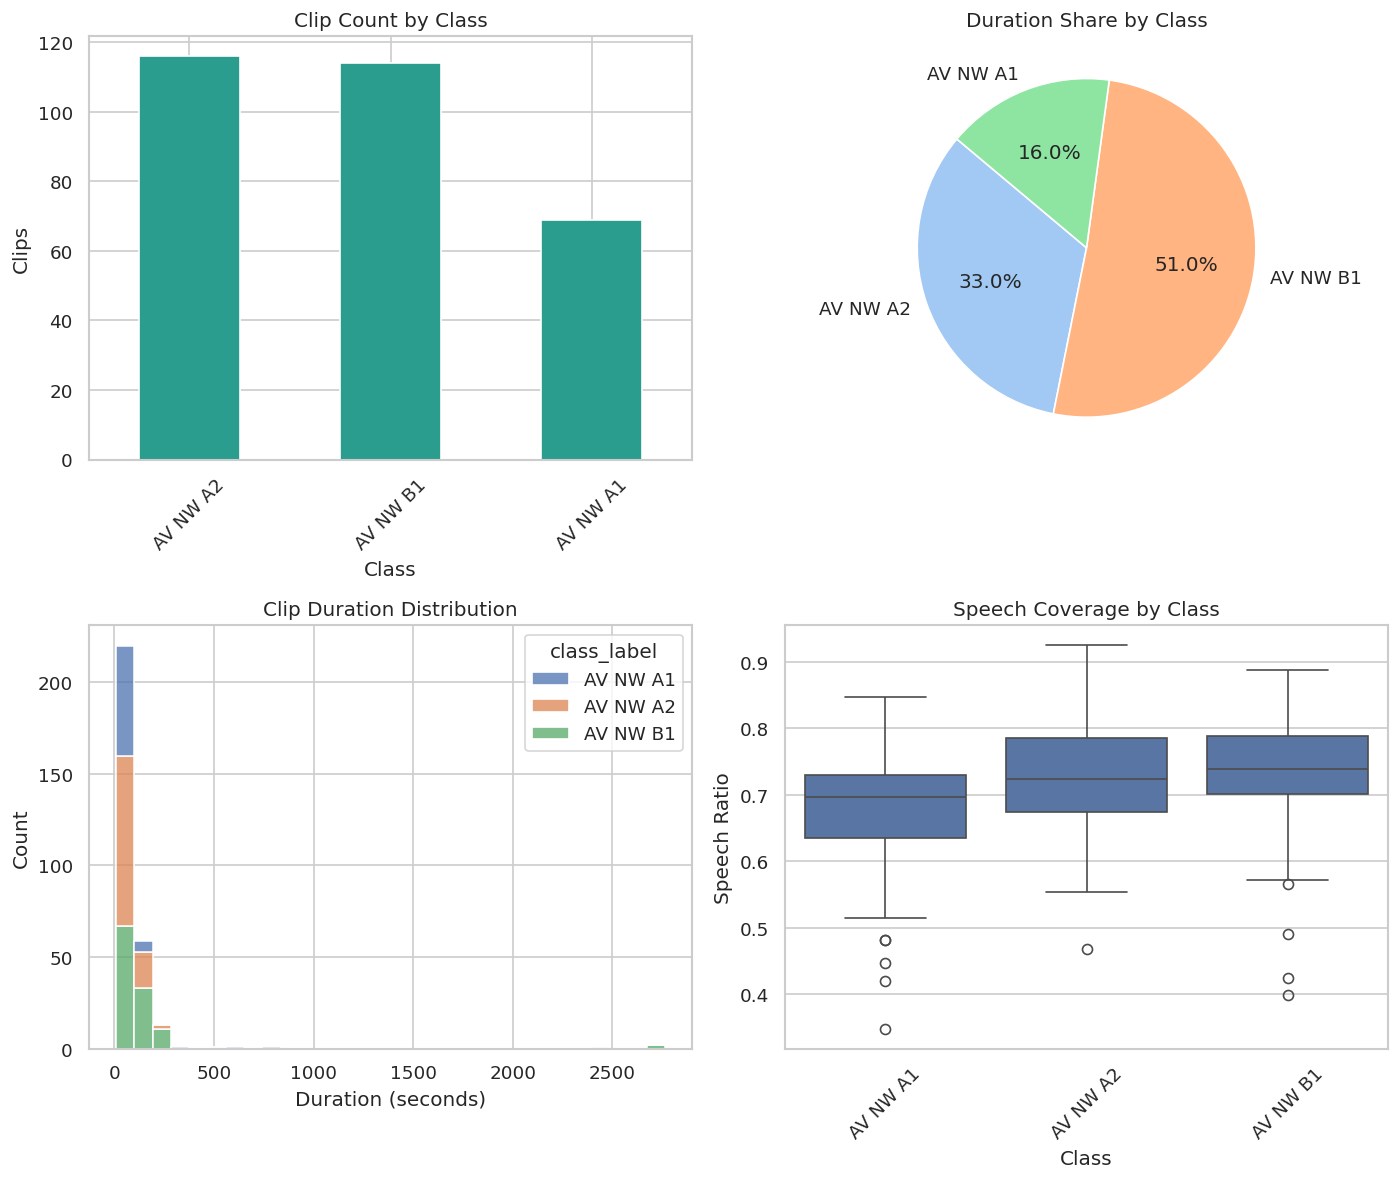

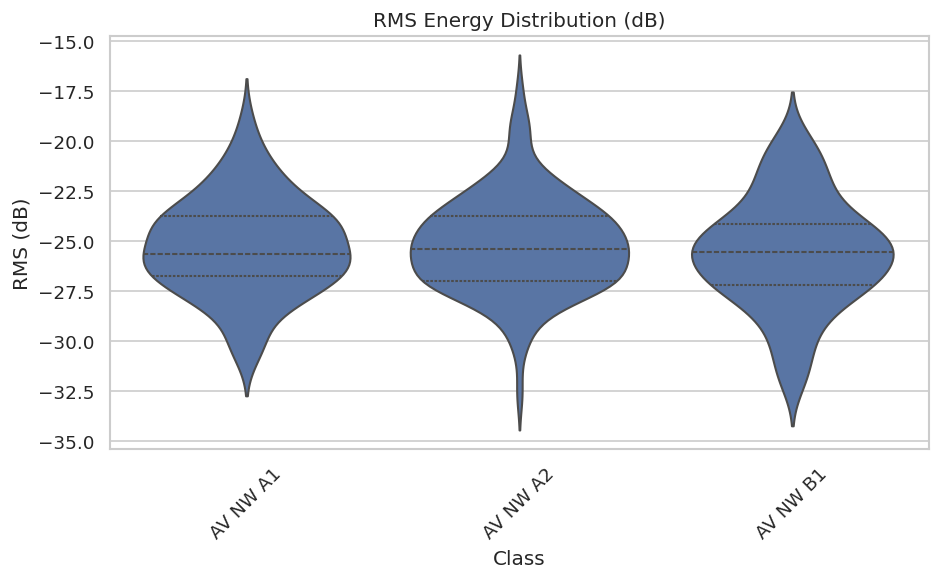


Saved artifacts:
 - detail_csv: /home/arvin/Project/welsh-test/notebooks/reports/North/North_clip_inventory.csv
 - summary_csv: /home/arvin/Project/welsh-test/notebooks/reports/North/North_class_summary.csv
 - figure_paths: /home/arvin/Project/welsh-test/notebooks/reports/North/North_figure_1.png
 - figure_paths: /home/arvin/Project/welsh-test/notebooks/reports/North/North_figure_2.png
 - text_report: /home/arvin/Project/welsh-test/notebooks/reports/North/dataset_overview.txt


In [16]:
north_config = AuditConfig(
    dataset_root=Path("..").resolve() / "datasets/North",
    speech_top_db=30.0,
    target_sr_for_speech_ratio=16000,
    reports_dir=Path.cwd() / "reports/North",
    save_tables=True,
    save_figures=True,
    save_text_report=True,
    text_report_name="dataset_overview.txt",
)
results = run_dataset_audit(north_config)

### South

Processing AV SW B1: 100%|██████████| 104/104 [00:31<00:00,  3.29it/s]


,file_count,total_duration_sec,avg_duration_sec,std_duration_sec,median_duration_sec,avg_speech_ratio,std_speech_ratio,avg_rms_db,avg_zero_cross_rate,samplerate_mode,samplerate_variety,total_filesize_mb,total_duration_hours
class_label,,,,,,,,,,,,,
AV SW A1,123,9461.719750,76.9s,64.3s,64.9s,71.6%,7.9%,-26.7 dB,12.91%,16000.0,1,110.7 MB,2.63h
AV SW A2,110,10868.958500,98.8s,213.5s,74.1s,73.2%,8.0%,-24.0 dB,13.95%,16000.0,1,118.9 MB,3.02h
AV SW B1,104,16079.174812,154.6s,367.2s,92.2s,73.1%,10.3%,-25.3 dB,12.63%,16000.0,1,260.1 MB,4.47h


Loaded 337 audio clips from 3 classes
Total audio duration: 10.11 hours
Total file size: 0.48 GB
Sample rate distribution (Hz):
samplerate
16000    337

Speech ratio (mean ± std) by class (%):
             mean_%  std_%
class_label               
AV SW A1      71.58   7.94
AV SW A2      73.19   7.98
AV SW B1      73.07  10.27


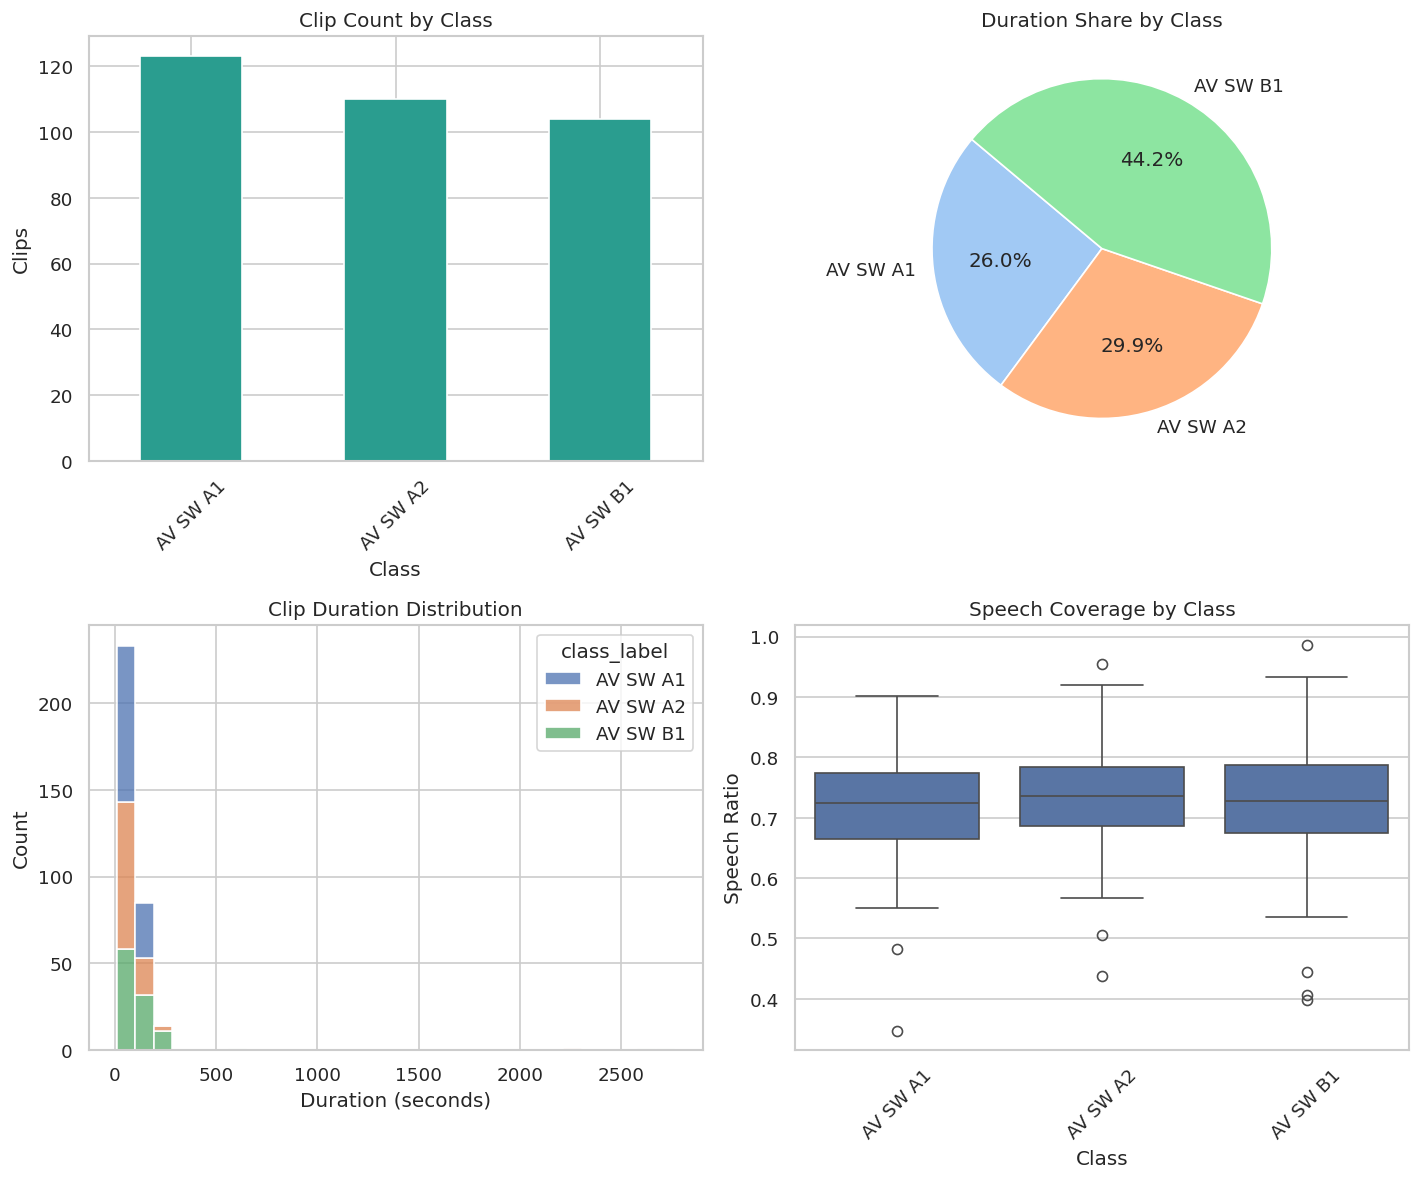

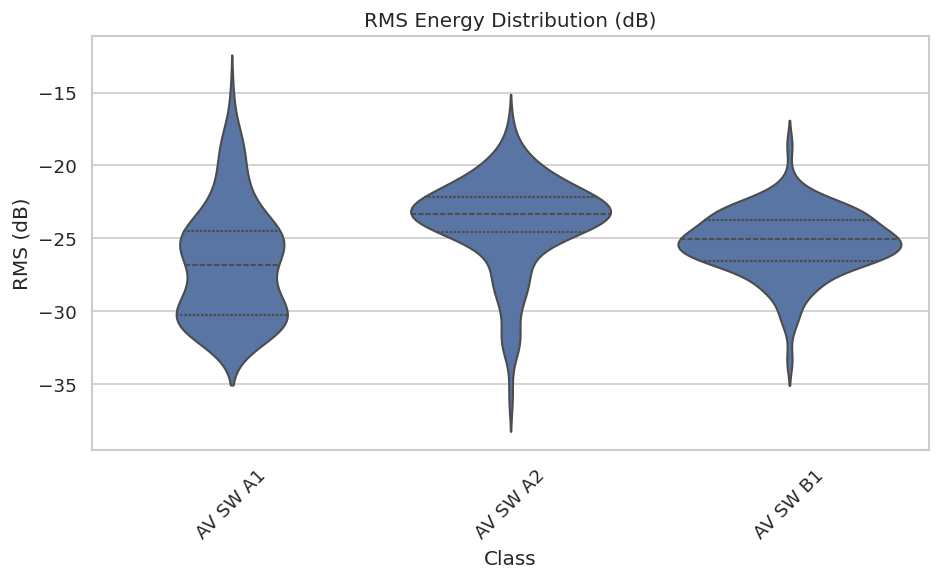


Saved artifacts:
 - detail_csv: /home/arvin/Project/welsh-test/notebooks/reports/South/South_clip_inventory.csv
 - summary_csv: /home/arvin/Project/welsh-test/notebooks/reports/South/South_class_summary.csv
 - figure_paths: /home/arvin/Project/welsh-test/notebooks/reports/South/South_figure_1.png
 - figure_paths: /home/arvin/Project/welsh-test/notebooks/reports/South/South_figure_2.png
 - text_report: /home/arvin/Project/welsh-test/notebooks/reports/South/dataset_overview.txt


In [17]:
south_config = AuditConfig(
    dataset_root=Path("..").resolve() / "datasets/South",
    speech_top_db=30.0,
    target_sr_for_speech_ratio=16000,
    reports_dir=Path.cwd() / "reports/South",
    save_tables=True,
    save_figures=True,
    save_text_report=True,
    text_report_name="dataset_overview.txt",
)
results = run_dataset_audit(south_config)

### B2

Processing AV B2 3: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


,file_count,total_duration_sec,avg_duration_sec,std_duration_sec,median_duration_sec,avg_speech_ratio,std_speech_ratio,avg_rms_db,avg_zero_cross_rate,samplerate_mode,samplerate_variety,total_filesize_mb,total_duration_hours
class_label,,,,,,,,,,,,,
AV B2 2 v2,27,2459.464812,91.1s,47.2s,76.5s,73.8%,23.5%,-28.8 dB,14.65%,16000.0,1,31.6 MB,0.68h
AV B2 1,20,2625.131500,131.3s,57.3s,118.5s,76.1%,9.6%,-25.2 dB,12.23%,16000.0,1,35.0 MB,0.73h
AV B2 2 v1,16,2588.956625,161.8s,100.7s,136.3s,87.3%,12.6%,-23.6 dB,12.41%,16000.0,1,42.9 MB,0.72h
AV B2 3,13,2980.428625,229.3s,104.1s,226.0s,92.5%,6.7%,-25.2 dB,12.49%,16000.0,1,55.9 MB,0.83h


Loaded 76 audio clips from 4 classes
Total audio duration: 2.96 hours
Total file size: 0.16 GB
Sample rate distribution (Hz):
samplerate
16000    76

Speech ratio (mean ± std) by class (%):
             mean_%  std_%
class_label               
AV B2 2 v2    73.80  23.48
AV B2 1       76.14   9.56
AV B2 2 v1    87.34  12.60
AV B2 3       92.55   6.75


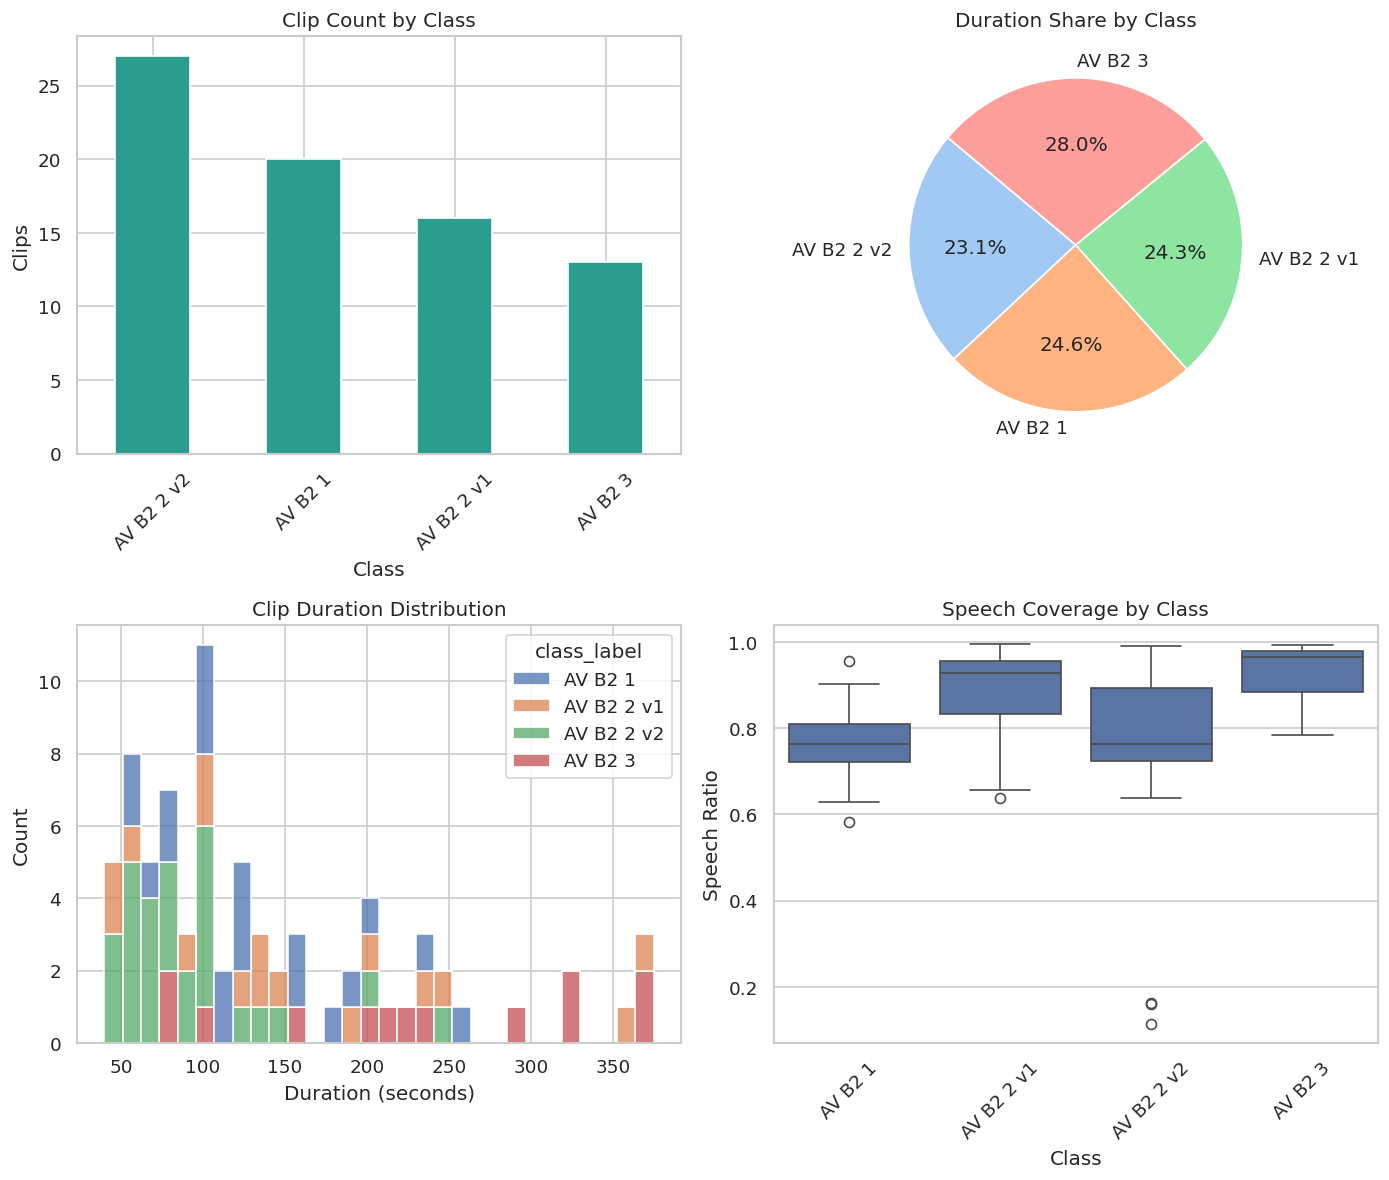

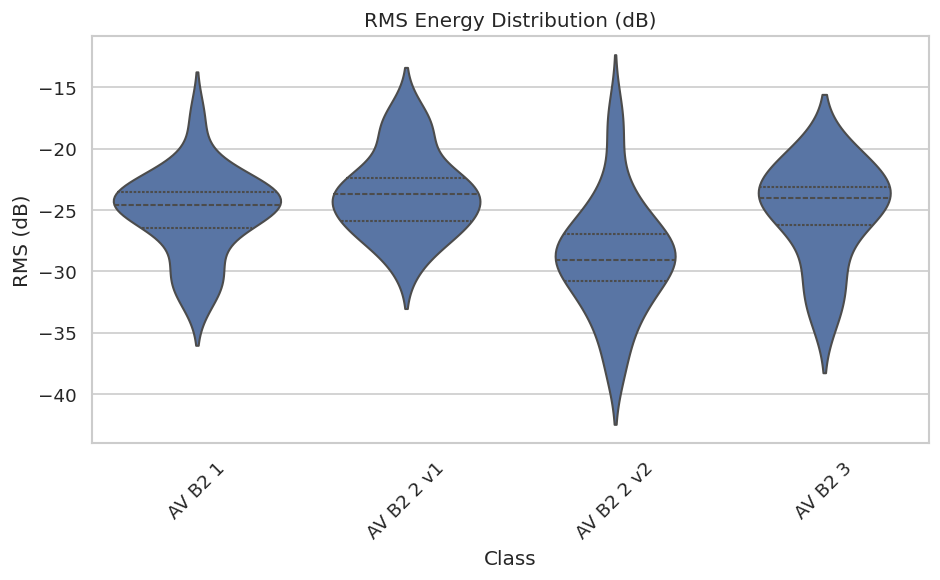


Saved artifacts:
 - detail_csv: /home/arvin/Project/welsh-test/notebooks/reports/B2/B2_clip_inventory.csv
 - summary_csv: /home/arvin/Project/welsh-test/notebooks/reports/B2/B2_class_summary.csv
 - figure_paths: /home/arvin/Project/welsh-test/notebooks/reports/B2/B2_figure_1.png
 - figure_paths: /home/arvin/Project/welsh-test/notebooks/reports/B2/B2_figure_2.png
 - text_report: /home/arvin/Project/welsh-test/notebooks/reports/B2/dataset_overview.txt


In [18]:
b2_config = AuditConfig(
    dataset_root=Path("..").resolve() / "datasets/B2",
    speech_top_db=30.0,
    target_sr_for_speech_ratio=16000,
    reports_dir=Path.cwd() / "reports/B2",
    save_tables=True,
    save_figures=True,
    save_text_report=True,
    text_report_name="dataset_overview.txt",
)
results = run_dataset_audit(b2_config)

### Common Voices

Processing clips: 100%|██████████| 115915/115915 [17:20<00:00, 111.43it/s]


,file_count,total_duration_sec,avg_duration_sec,std_duration_sec,median_duration_sec,avg_speech_ratio,std_speech_ratio,avg_rms_db,avg_zero_cross_rate,samplerate_mode,samplerate_variety,total_filesize_mb,total_duration_hours
class_label,,,,,,,,,,,,,
clips,115915,569723.973,4.9s,1.7s,4.7s,64.9%,14.2%,-24.2 dB,16.71%,16000.0,1,4101.5 MB,158.26h


Loaded 115915 audio clips from 1 classes
Total audio duration: 158.26 hours
Total file size: 4.01 GB
Sample rate distribution (Hz):
samplerate
16000    115915

Speech ratio (mean ± std) by class (%):
             mean_%  std_%
class_label               
clips         64.86  14.21


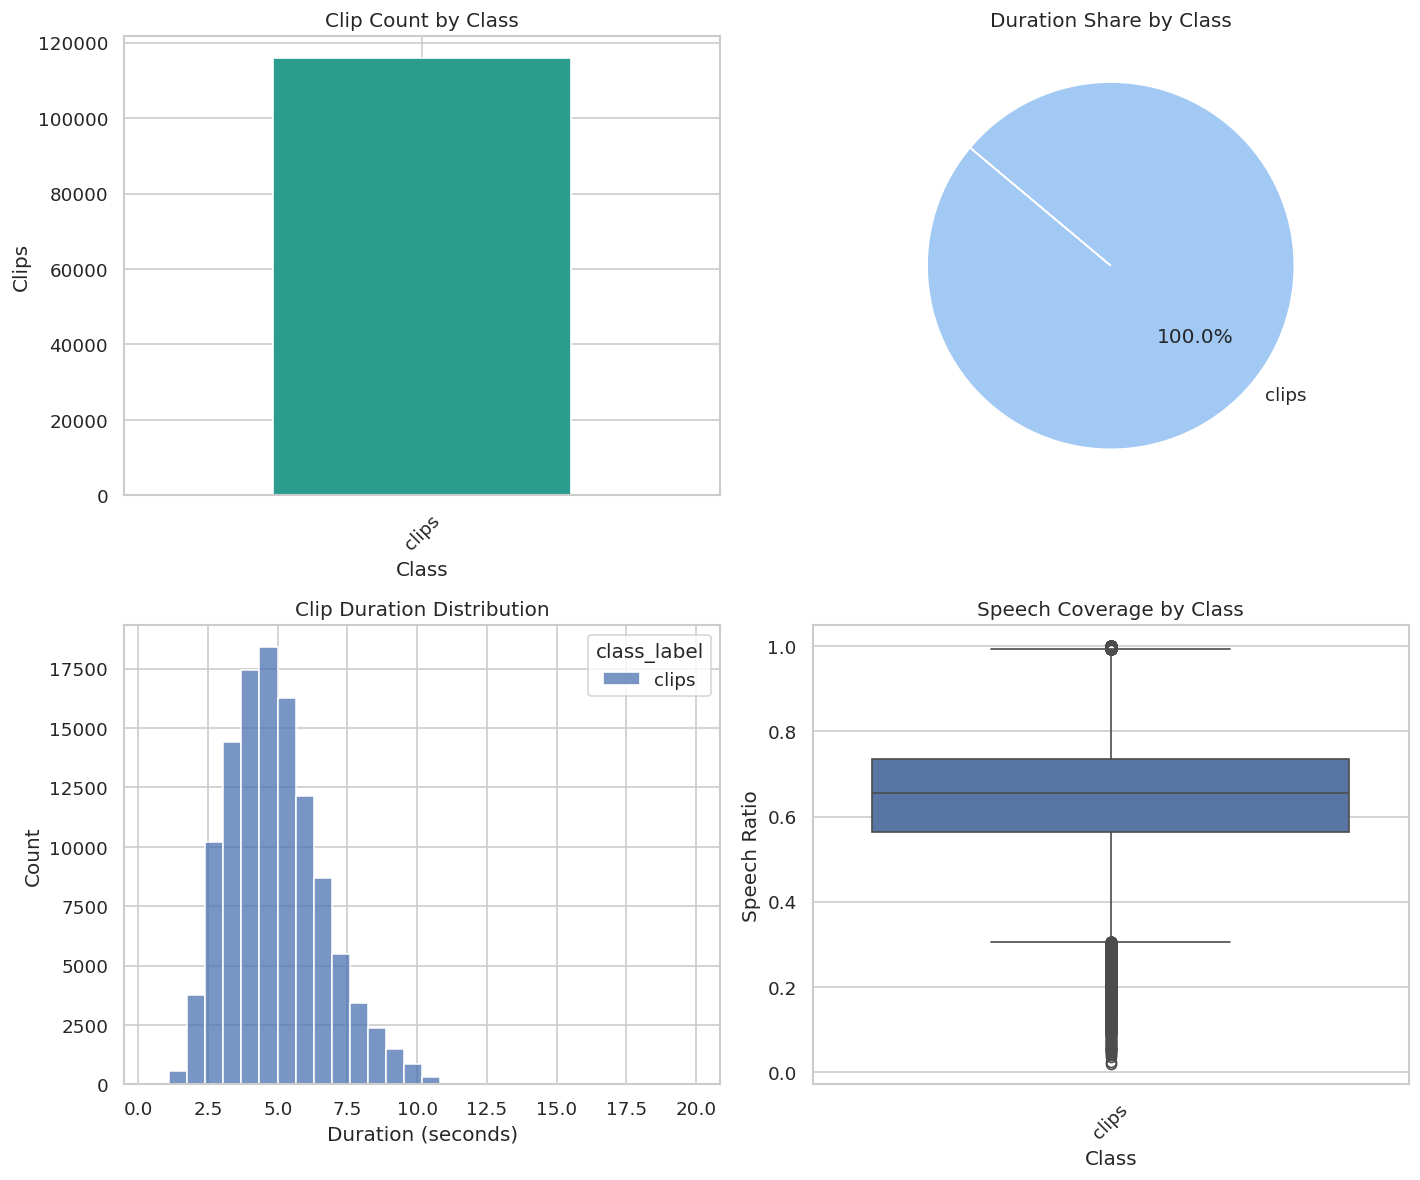

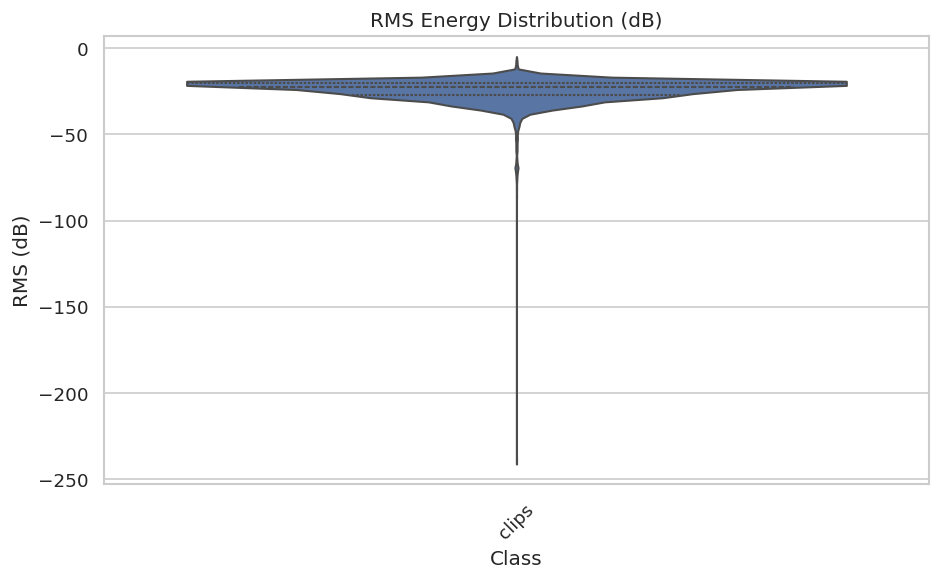


Saved artifacts:
 - detail_csv: /home/arvin/Project/welsh-test/notebooks/reports/CommonVoices/CommonV_clip_inventory.csv
 - summary_csv: /home/arvin/Project/welsh-test/notebooks/reports/CommonVoices/CommonV_class_summary.csv
 - figure_paths: /home/arvin/Project/welsh-test/notebooks/reports/CommonVoices/CommonV_figure_1.png
 - figure_paths: /home/arvin/Project/welsh-test/notebooks/reports/CommonVoices/CommonV_figure_2.png
 - text_report: /home/arvin/Project/welsh-test/notebooks/reports/CommonVoices/dataset_overview.txt


In [19]:
cv_config = AuditConfig(
    dataset_root=Path("..").resolve() / "datasets/CommonV",
    speech_top_db=30.0,
    target_sr_for_speech_ratio=16000,
    reports_dir=Path.cwd() / "reports/CommonVoices",
    save_tables=True,
    save_figures=True,
    save_text_report=True,
    text_report_name="dataset_overview.txt",
)
results = run_dataset_audit(cv_config)